# Bayesian Inference with Stan

**Source**: [Bayesian Inference with Stan](https://nicholasrjenkins.science/tutorials/bayesian-inference-with-stan/)

### Bayesian Workflow

In general the Bayesian workflow consists of steps:

- Consider the social process that generates your data. The goal of your statistical model should be to model the data generating process, so think hard about this. Exploratory analysis goes a long way towards helping you to understand this process.
- Program your statistical model and sample from it.
- Evaluate your model’s reliability. Check for Markov chain convergence to make sure that your model has produced reliable estimates.
- Evaluate your model’s performance. How well does your model approximate the data generating process? This involves using posterior predictive checks.
- Summarize your model’s results in tabular and graphical form.

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
from cmdstanpy import CmdStanModel

from matplotlib import style 
style.use('../../PlottingStyle.mplstyle')

import gc

%config InlineBackend.figure_formats = ['svg']

In [2]:
def bw_nrd0(x):
    if len(x) < 2:
        raise(Exception("need at least 2 data points"))

    hi = np.std(x, ddof=1)
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    lo = min(hi, iqr/1.34)
    
    lo = lo or hi or abs(x[0]) or 1

    return 0.9 * lo *len(x)**-0.2

In [3]:
def StanModel(stan_file: str, stan_code: str) -> CmdStanModel:
    """Load or compile a Stan model"""
    stan_src = f"{stan_file}.stan"

    if not os.path.isfile(stan_file):  
        open(stan_src, 'w').write(stan_code)  # Write Stan code if needed
        return CmdStanModel(stan_file=stan_src, cpp_options={'STAN_THREADS': 'true', 'parallel_chains': 4})
    
    return CmdStanModel(stan_file=stan_src, exe_file=stan_file)

### Stan Syntax

Stan requires the coding of your model in different blocks and in a specific order. In order, these blocks are data, transformed data, parameters, transformed parameters, model, and generated quantities. Let’s suppose that we wanted to estimate the following equation with Stan:

$$
\begin{aligned}
y &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha + \beta x \\
\alpha &\sim \text{Normal}(0, 10)\\
\beta &\sim \text{Normal}(0, 10)\\
\sigma &\sim \text{Unifrom}(0, 100)\\
\end{aligned}
$$

A complete Stan program for this model looks like the following:

In [4]:
linear_reg_1 = '''
data {              // This is the data block
    int N;          // Specify Sample Size
    array[N] real y;      // A variable named y with length n
    array[N] real x;      // A variable named x with length n
}

transformed data {
  // this is where you could specify variable transformations
}

parameters {        // Block for parameters to be estimated
  real a;           // A parameter named a
  real b;           // A parameter named b
  real sigma;       // A parameter named sigma
}

transformed parameters {
  // Here you could specify transformations of your parameters
}

model {
  vector[N] mu;     // create the linear predictor mu

  // Write the linear model
  for (i in 1:N) {
    mu[i] = a + b * x[i];
  }

  // Write out priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ uniform(0, 100);

  // Write out the likelihood function
  for (i in 1:N) {
  y[i] ~ normal(mu[i], sigma);
  }
}

generated quantities {
  // Here you can calculate things like log-likelihood, replication data, etc.
}
'''

stan_model = StanModel('./stan_models/linear_reg_1', linear_reg_1)

After programming the model, you run the code which will tell Python to compile it into a model. From there we are ready to sample from the model. Note that Stan is case sensitive and each line must terminate with a semi-colon “;”.

### Example: Exploratory Analysis

In [5]:
mpg = pd.read_csv('../../data/mpg.csv', sep=',', header=0)
mpg.head()

manufacturer model  displ  year  cyl       trans drv  cty  hwy fl    class
0         audi    a4    1.8  1999    4    auto(l5)   f   18   29  p  compact
1         audi    a4    1.8  1999    4  manual(m5)   f   21   29  p  compact
2         audi    a4    2.0  2008    4  manual(m6)   f   20   31  p  compact
3         audi    a4    2.0  2008    4    auto(av)   f   21   30  p  compact
4         audi    a4    2.8  1999    6    auto(l5)   f   16   26  p  compact

This data set contains data on the make and model over different cars along with their engine type, transmission type, and mpg. Let’s do some visualizations to get a better understanding of our data.

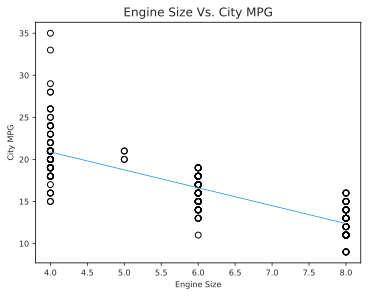

In [6]:
m, b = np.polyfit(mpg.cyl, mpg.cty, 1)
plt.plot(mpg.cyl, mpg.cty, 'o', fillstyle='none')
plt.plot(mpg.cyl, m * mpg.cyl + b)
plt.title('Engine Size Vs. City MPG')
plt.xlabel('Engine Size')
plt.ylabel('City MPG');

As expected, there is a negative relationship between engine size and city MPG. Let’s build a simple linear model to see if engine type affects mpg. In mathematical notation, this model would look like:

$$
\begin{aligned}
mpg_i &\sim \text{Normal}(\mu_i, \sigma)\\
\mu_i &= \alpha + \beta \times \text{Engine}_i \\
\alpha &\sim \text{Normal}(0, 100)\\
\beta &\sim \text{Normal}(0, 100)\\
\sigma &\sim \text{Unifrom}(0, 100)\\
\end{aligned}
$$


#### Prior Simulation

Notice that I am specifying pretty uninformative priors. To see just how uninformative, let’s do some simulations. Centering continuous variables can also help to interpret priors.

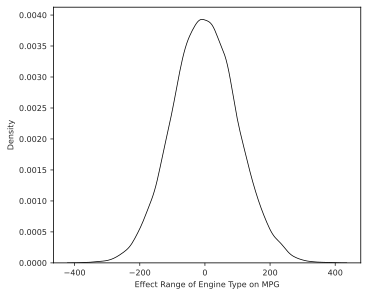

In [7]:
# draw from a normal distribution
sim_data = np.random.normal(0, 100, 10_000)

sns.kdeplot(sim_data)
plt.xlabel('Effect Range of Engine Type on MPG')
plt.ylabel('Density');

So, we are telling the model that the average effect of engine type on MPG will be zero, but can range between a decrease of 200 and an increase of 200 MPG with reasonably high probability. Thus, this is a pretty flat prior. Cars with bigger engines will probably get lower MPG, but they probably don’t get 200 MPG lower! This is a good time to point out that uninformative priors are rarely ever a good idea since we almost always know something about the effects we are interested in before we estimate them.

Finally, let’s examine the prior for $\sigma$.

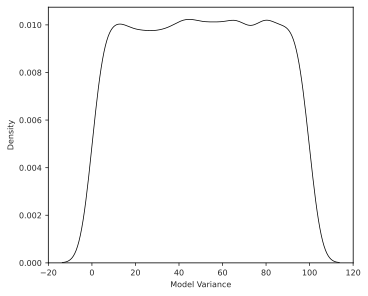

In [8]:
sim_data = np.random.uniform(0, 100, 10_000)

sns.kdeplot(sim_data)
plt.xlabel('Model Variance')
plt.ylabel('Density');

#### Model Programming

Now that we know what we are telling the model a priori, let’s program the model.

##### Vectorized Syntax

In [9]:
mpg_model_1 = '''
data {              
    int N;                      // Number of observations (rows of data)
    vector[N] mpg;              // Variable called mpg as a vector of length N
    vector[N] engine;           // Variable called engine as a vector of length N
}
parameters {        
  real alpha;                   // This will be our intercept
  real beta;                    // This will be our slope
  real sigma;                   // This will be our variance parameter
}
model {
  vector[N] mu;                 // Create the linear predictor mu
  mu = alpha + beta * engine;   // Write the linear combination

  // Priors
  alpha ~ normal(0, 100);
  beta ~ normal(0, 100);
  sigma ~ uniform(0, 100);

  // Likelihood function
  mpg ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;          // Calculate Log-Likelihood
    vector[N] y_rep;            // Replications from posterior predictive distribution
    
    for (i in 1:N) {
        // generate mpg predicted value
        real mpg_hat = alpha + beta * engine[i];
        
        // calculate log-likelihood
        log_lik[i] = normal_lpdf(mpg[i] | mpg_hat, sigma);
        // normal_lpdf is the log of the normal probability density function
        
        // generate replication values
        y_rep[i] = normal_rng(mpg_hat, sigma);
        // normal_rng generates random numbers from a normal distribution
        
    }
}
'''

stan_model = StanModel('./stan_models/mpg_model_1', mpg_model_1)

##### Target+ Syntax

Stan allows users to directly specify the log-posterior using target+ syntax. Using this syntax, `y ~ normal(mu, sigma)`; becomes `target += normal_lpdf(y | mu, sigma)`. This directly updates the target log density.

In [10]:
mpg_model_1a = '''
data {              
    int N;                      // Number of observations (rows of data)
    vector[N] mpg;              // Variable called mpg as a vector of length n
    vector[N] engine;            // Variable called weight as a vector of length n
}
parameters {        
  real alpha;                   // This will be our intercept
  real beta;                    // This will be our slope
  real sigma;                   // This will be our variance parameter
}
model {
  vector[N] mu;                 // Create the linear predictor mu
  mu = alpha + beta * engine;   // Write the linear combination

  // Priors
  target += normal_lpdf(alpha | 0, 100);
  target += normal_lpdf(beta | 0, 100);
  target += uniform_lpdf(sigma | 0, 100);

  // Likelihood function
  target += normal_lpdf(mpg | mu, sigma);
}

generated quantities {
    vector[N] log_lik;          // Calculate Log-Likelihood
    vector[N] y_rep;            // Replications from posterior predictive distribution
    
    for (i in 1:N) {
        // generate mpg predicted value
        real mpg_hat = alpha + beta * engine[i];
        
        // calculate log-likelihood
        log_lik[i] = normal_lpdf(mpg[i] | mpg_hat, sigma);
        // normal_lpdf is the log of the normal probability density function
        
        // generate replication values
        y_rep[i] = normal_rng(mpg_hat, sigma);
        // normal_rng generates random numbers from a normal distribution
        
    }
}
'''

stan_model = StanModel('./stan_models/mpg_model_1a', mpg_model_1a)

Now, let’s get into running some linear models.

In [11]:
exceptions = ['In', 'exceptions', 'active_variables']

active_variables = [
    var for var, value in globals().items()
    if not var.startswith('_')   # Exclude variables that start with "_"
    and var not in exceptions    # Exclude variables in the exceptions list
    and isinstance(value, (CmdStanModel, pd.DataFrame, pd.Series, list, int, float, str, np.ndarray, np.int64, np.float32))  # Remove these types only
]

for var in active_variables:
    del globals()[var]
del active_variables, exceptions, var

gc.collect()

3293

## Linear Models in Stan

#### Import Data

We’ll use the Motor Trend Car Road Tests `mtcars` data as our practice data set.

Let’s walk though what our variables are:

- `mpg`: Miles pre gallon
- `cyl`: Number of cylinders
- `disp` Displacement (cu. in.)
- `hp`: Gross horsepower
- `drat`: Rear axle ratio
- `wt`: Weight (1000 lbs)
- `qsec`: 1/4 mile time
- `vs`: Engine (0 = V-shaped, 1 = straight)
- `am`: Transmission (0 = automatic, 1 = manual)
- `gear`: Number of forward gears
- `carb`: Number of carburetors

In [12]:
mtcars = pd.read_csv('../../data/mtcars.csv', sep=',', header=0)
mtcars.head()

model   mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
0          Mazda RX4  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
1      Mazda RX4 Wag  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
2         Datsun 710  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
3     Hornet 4 Drive  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
4  Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

   carb  
0     4  
1     4  
2     1  
3     1  
4     2

For our research question, we will be investigating how different characteristics of a car affect it’s MPG. To start with, we will test how vehicle weight affects MPG. Let’s do some preliminary analysis of this question with visualizations.

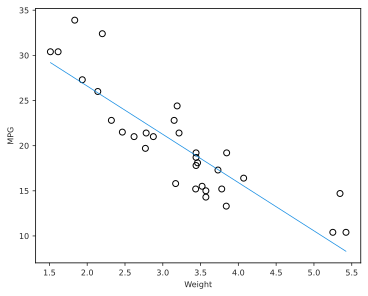

In [13]:
m, b = np.polyfit(mtcars.wt, mtcars.mpg, 1)
plt.plot(mtcars.wt, mtcars.mpg, 'o', fillstyle='none')
plt.plot(mtcars.wt, m * mtcars.wt + b)
plt.xlabel('Weight')
plt.ylabel('MPG');

As expected, there seems to be a negative relationship between these variables. Let’s add in a fitted line:

#### Build a Model - Models with a Single Predictor

Now we will build a model in Stan to formally estimate this relationship. 

Here is the model that we want to estimate in Stan:
$$
\begin{aligned}
mpg_i &\sim \text{Normal}(\mu_, \sigma)\\
\mu_i &= \alpha + \beta \times \text{Weight} \\
\end{aligned}
$$

Now, program the model:

In [14]:
mtcar_model_1 = '''
data {              
    int N;                      // Number of observations (rows of data)
    vector[N] mpg;              // Variable called mpg as a vector of length N
    vector[N] weight;           // Variable called weight as a vector of length N
}
parameters {        
  real alpha;                   // This will be our intercept
  real beta_w;                  // This will be our slope
  real<lower=0> sigma;          // This will be our variance parameter
                                // variance parameter and restrict it to positive values
}
model {
  vector[N] mu;                 // Create the linear predictor mu
  mu = alpha + beta_w * weight;   // Write the linear combination

  // Likelihood function
  mpg ~ normal(mu, sigma);
}
'''

stan_model = StanModel('./stan_models/mtcar_model_1', mtcar_model_1)

Once we finish writing the model, we need to run the code block to compile it into C++ code. This will also us to sample from the model and obtain the parameter estimates. Let’s do that now.

The next step is to prepare the data for Stan. Stan can’t use the same types of data that python can. For example, Stan requires dictionary, not data frames, and it cannot accept factors. 

In [15]:
model_data = {
    'mpg': mtcars.mpg,
    'weight': mtcars.wt,
    'N': len(mtcars.mpg)
}

linear_fit_1 = stan_model.sample(data=model_data, show_progress=False)

14:49:56 - cmdstanpy - INFO - CmdStan start processing
14:49:56 - cmdstanpy - INFO - CmdStan start processing
14:49:56 - cmdstanpy - INFO - CmdStan done processing


In [16]:
# summarize our model
linear_fit_1.summary(percentiles=(5, 95)).round(2)

Mean  MCSE  StdDev   MAD     5%    95%  ESS_bulk  ESS_tail  R_hat
lp__   -51.09  0.04    1.26  1.00 -53.53 -49.73   1203.06   1426.82   1.00
alpha   37.26  0.06    2.00  1.99  33.94  40.54   1210.95   1195.53   1.01
beta_w  -5.33  0.02    0.59  0.58  -6.31  -4.34   1208.96   1117.70   1.01
sigma    3.18  0.01    0.43  0.42   2.55   3.93   1493.27   1905.47   1.00

Let’s run through the interpretation of this model:
- `alpha` For a car with a weight of zero, the expected MPG is 37.38. Obviously, a weight of zero is impossible, so we’ll want to address this in our next model.
- `beta_w` Comparing two cars who differ by 1000 pounds, the model predicts a difference of 5.38 miles per gallon.
- `sigma` The model predicts MPG within 3.17 points.
- `lp__` Logarithm of the (unnormalized) posterior density. This log density can be used in various ways for model evaluation and comparison.

Ok, now that we’ve written our model, let’s make a few improvements. First, let’s center our weight variable so that we can get a more meaningful interpretation of the intercept parameter alpha. We can accomplish this by subtracting the mean from each observation. This will change the interpretation of the intercept to be the average MPG when weight is held constant at it’s average value.

In [17]:
mtcars['wt_c'] = mtcars.wt - mtcars.wt.mean()

Now that we changed the name of the variable name, we also need to change our model code to incorporate this change. While we are adjusting the code, we’ll also restrict the scale parameter to be positive. This will help our model be a bit more efficient.

In [18]:
mtcar_model_2 = '''
data {              
    int N;                      // Number of observations (rows of data)
    vector[N] mpg;              // Variable called mpg as a vector of length N
    vector[N] weight_c;         // Variable called weight as a vector of length N
}
parameters {        
  real alpha;                   // This will be our intercept
  real beta_w;                  // This will be our slope
  real<lower=0> sigma;          // This will be our variance parameter
                                // variance parameter and restrict it to positive values
}
model {
  vector[N] mu;                 // Create the linear predictor mu
  mu = alpha + beta_w * weight_c;   // Write the linear combination

  // Likelihood function
  mpg ~ normal(mu, sigma);
}
'''

stan_model = StanModel('./stan_models/mtcar_model_2', mtcar_model_2)

In [19]:
model_data = {
    'mpg': mtcars.mpg,
    'weight_c': mtcars.wt_c,
    'N': len(mtcars.mpg)
}

linear_fit_2 = stan_model.sample(data=model_data, show_progress=False)

14:49:57 - cmdstanpy - INFO - CmdStan start processing
14:49:57 - cmdstanpy - INFO - CmdStan start processing
14:49:57 - cmdstanpy - INFO - CmdStan done processing


In [20]:
# summarize our model
linear_fit_2.summary(percentiles=(5, 95)).round(2)

Mean  MCSE  StdDev   MAD     5%    95%  ESS_bulk  ESS_tail  R_hat
lp__   -51.10  0.03    1.28  1.02 -53.65 -49.72   1660.10   2276.84    1.0
alpha   20.10  0.01    0.59  0.57  19.13  21.05   3376.71   2463.01    1.0
beta_w  -5.34  0.01    0.58  0.58  -6.27  -4.40   3337.33   2736.70    1.0
sigma    3.19  0.01    0.43  0.40   2.57   4.00   3157.03   2678.52    1.0

Let’s interpret this model:
- `alpha` When a vehicle’s weight is held at its average value, the expected MPG is 20.09.
- `beta_w` This estimate has the same interpretation as before.
- `sigma` This estimate has the same interpretation as before.
- `lp__` This estimate has a relatively similar value (in absolute value) than it did in the previous model indicating that it performed more or less the same.

#### Build a Model - Models with Multiple Predictors

To add more predictors, we just need to adjust out model code. Let’s add in the vehicle’s cylinders and horsepower. We’ll also center these variables.

In [21]:
mtcar_model_3 = '''
data {              
    int N;                        // Number of observations (rows of data)
    vector[N] mpg;                // vector of length n for the car's MPG
    vector[N] weight_c;           // vector of length n for the car's weight
    vector[N] cylinders_c;        // vector of length n for the car's cylinders
    vector[N] hp_c;               // vector of length n for the car's horsepower
}
parameters {        
    real alpha;                   // Intercept parameter
    real beta_w;                  // Weight slope parameter
    real beta_c;                  // Cylinder slope parameter
    real beta_h;                  // Horsepower slope parameter
    real<lower=0> sigma;          // variance parameter and restrict it to positive values
}
model {
  vector[N] mu;                    // Linear predictor mu
  
  // Linear equation
  mu = alpha + beta_w * weight_c + beta_c * cylinders_c + beta_h * hp_c;

  // Likelihood function
  mpg ~ normal(mu, sigma);
}
'''

stan_model = StanModel('./stan_models/mtcar_model_3', mtcar_model_3)

In [22]:
mtcars['cyl_c'] = mtcars.cyl - mtcars.cyl.mean()
mtcars['hp_c'] = mtcars.hp - mtcars.hp.mean()

model_data = {
    'mpg': mtcars.mpg,
    'weight_c': mtcars.wt_c,
    'cylinders_c': mtcars.cyl_c,
    'hp_c': mtcars.hp_c,
    'N': len(mtcars.mpg)
}

linear_fit_3 = stan_model.sample(data=model_data, show_progress=False)

14:49:57 - cmdstanpy - INFO - CmdStan start processing
14:49:57 - cmdstanpy - INFO - CmdStan start processing
14:49:57 - cmdstanpy - INFO - CmdStan done processing


In [23]:
# summarize our model
linear_fit_3.summary(percentiles=(5, 95)).round(2)

Mean  MCSE  StdDev   MAD     5%    95%  ESS_bulk  ESS_tail  R_hat
lp__   -45.10  0.04    1.72  1.49 -48.44 -43.05   1581.24   2551.28    1.0
alpha   20.09  0.01    0.47  0.45  19.34  20.87   3241.44   2342.06    1.0
beta_w  -3.18  0.01    0.76  0.76  -4.44  -1.93   3219.29   2580.79    1.0
beta_c  -0.92  0.01    0.56  0.55  -1.85   0.01   2583.58   2454.79    1.0
beta_h  -0.02  0.00    0.01  0.01  -0.04   0.00   2485.02   2674.51    1.0
sigma    2.63  0.01    0.37  0.35   2.11   3.29   3177.09   2497.94    1.0

After adjusting for a car’s cylinders and horsepower two cars that differ by 1000 pounds, the model predicts a difference of 3.18 miles per gallon. Notice that `lp__` is now even lower, suggesting that this latest model is a better fit.

#### Assessing Our Model

In [24]:
print(linear_fit_3.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



#### Model Convergence

Now that we’ve built a decent model, we need to see how well it actual preforms. First, we’ll want to check that our chains have converged and are producing reliable point estimates. We can do this with a traceplot.

In [25]:
# Convert CmdStanPy (CmdStanMCMC object) data into an InferenceData object 
az_linear_fit_3 = az.from_cmdstanpy(linear_fit_3)
az_linear_fit_3

Inference data with groups:
	> posterior
	> sample_stats

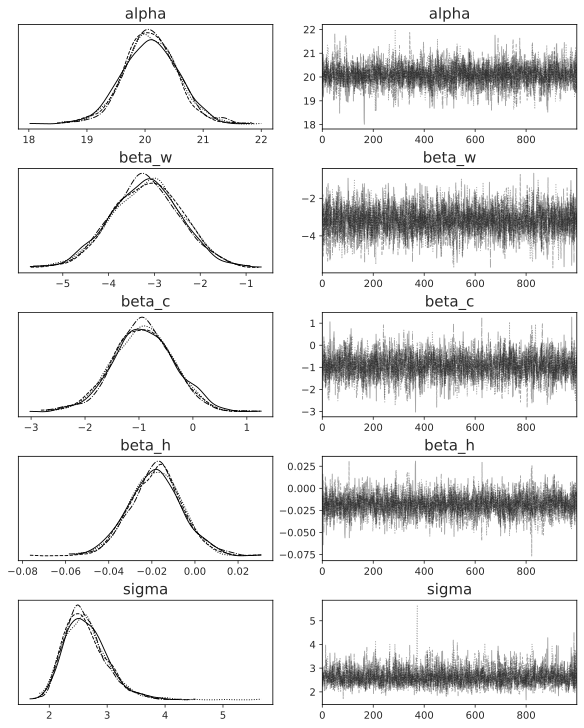

In [26]:
# extract the posterior draws and plot trace
_, ax = plt.subplots(5, 2, figsize=(8,10))
az.plot_trace(az_linear_fit_3, axes=ax);

The fuzzy caterpillar appearance indicates that the chains are mixing well and have converged to a common distribution. We can also assess the R-hat values for each parameter in the summary produces earlier. As a rule of thumb, R-hat values less than 1.05 indicate good convergence.

#### Effective Sample Size

The effective sample size estimates the number of independent draws from the posterior distribution of a given estimate. This metric is important because Markov chains can have autocorrelation which will lead to biased parameter estimates.

Try to visualize the ratio of the effective sample size to the total number of samples - the larger the ratio the better. The rule of thumb here is to worry about ratios less than 0.1.

#### Posterior Predictive Checks

One of the most powerful tools of Bayesian inference is to conduct posterior predictive checks. This check is designed to see how well our model can generate data that matches observed data. If we built a good model, it should be able to generate new observations that very closely resemble the observed data.

In order to perform posterior predictive checks, we will need to add in some code to our model. Specifically we need to calculate replications of our outcome variable. We can do this using the `generated quantities` section.

In [27]:
mtcar_model_3_ppc = '''
data {
    int N; //number of observations in the data
    vector[N] mpg; //vector of length n for the car's MPG
    vector[N] weight_c; //vector of length n for the car's weight
    vector[N] cylinders_c; ////vector of length n for the car's cylinders
    vector[N] hp_c; //vector of length n for the car's horsepower
}
parameters {
    real alpha; //the intercept parameter
    real beta_w; //slope parameter for weight
    real beta_c; //slope parameter for cylinder
    real beta_h; //slope parameter for horsepower
    real<lower=0> sigma; //variance parameter and restrict it to positive values
}
model {
    //linear predictor mu
    vector[N] mu;

    //write the linear equation
    mu = alpha + beta_w * weight_c + beta_c * cylinders_c + beta_h * hp_c;

    //likelihood function
    mpg ~ normal(mu, sigma);
}
generated quantities {
    //replications for the posterior predictive distribution
    array[N] real y_rep;
    y_rep = normal_rng(alpha + beta_w * weight_c + beta_c * 
    cylinders_c + beta_h * hp_c, sigma);
}
'''

stan_model = StanModel('./stan_models/mtcar_model_3_ppc', mtcar_model_3_ppc)

In the code block above, `normal_rng` is the Stan function to generate observations from a normal distribution. So, `y_rep` generates new data points from a normal distribution using the linear model we built `mu` and a variance `sigma`. Now let’s re-estimate the model:

In [28]:
# sample the model
linear_fit_3_ppc = stan_model.sample(data=model_data, show_progress=False)

14:49:58 - cmdstanpy - INFO - CmdStan start processing
14:49:58 - cmdstanpy - INFO - CmdStan start processing
14:49:59 - cmdstanpy - INFO - CmdStan done processing


In [29]:
# summarize the model
summary = linear_fit_3_ppc.summary(percentiles=(5, 95)).round(2)
summary[~summary.index.str.contains('y_rep')]

Mean  MCSE  StdDev   MAD     5%    95%  ESS_bulk  ESS_tail  R_hat
lp__   -45.17  0.05    1.70  1.51 -48.45 -43.08   1394.21   2071.78    1.0
alpha   20.07  0.01    0.48  0.47  19.28  20.86   3324.15   2168.10    1.0
beta_w  -3.17  0.01    0.75  0.74  -4.37  -1.90   3291.80   2759.51    1.0
beta_c  -0.95  0.01    0.57  0.57  -1.87  -0.01   2385.55   2079.82    1.0
beta_h  -0.02  0.00    0.01  0.01  -0.04   0.00   2660.46   2325.51    1.0
sigma    2.62  0.01    0.37  0.36   2.10   3.30   2985.01   2584.08    1.0

In our model output, we now have a replicated y value for every row of data. We can use these values to plot the replicated data against the observed data.

In [30]:
# Convert CmdStanPy (CmdStanMCMC object) data into an InferenceData object 
az_linear_fit_3 = az.from_cmdstanpy(linear_fit_3_ppc, posterior_predictive=['y_rep'], observed_data={'mpg': mtcars.mpg}, dtypes={"y_rep": float})
az_linear_fit_3

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

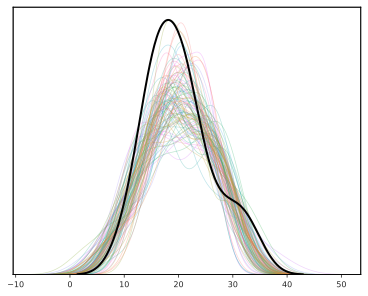

In [31]:
_, axes = plt.subplots()
sns.kdeplot(az_linear_fit_3.posterior_predictive.y_rep.to_numpy()[3, :100,:].T, legend=False, ax=axes, alpha=0.3)
ax2 = axes.twinx()
sns.kdeplot(mtcars.mpg, legend=False, ax=ax2, color='k', linewidth=2)
axes.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False);

The closer the replicated values (`yrep`) get to the observed values (`y`) the more accurate the model. Here it looks like we could probably do a bit better, though the lose fit is likely due to the small sample size (which adds more uncertainty).

#### Improving the Model with Better Priors

To improve this model, let’s use more informative priors. Priors allow us to incorporate our background knowledge on the question into the model to produce more realistic estimates. For our question here, we probably don’t expect the weight of a vehicle to change its MPG more that a dozen or so miles per gallon. Unfortunately, because we didn’t specify priors in the previous models, it defaulted to using flat priors which essentially place an equal probably on all possible coefficient values - not very realistic. Let’s fix that.

To get a better sense of what priors to use, it’s a good idea to use prior predictive checks, which are a lot like posterior predictive checks only they don’t include any data. The goal is to select priors that put some probably over all plausible vales.

#### Evaluate priors

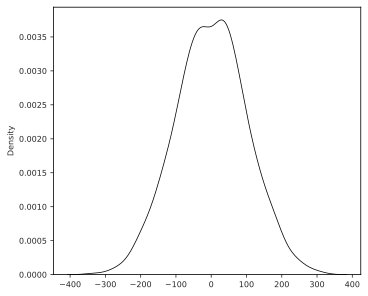

In [32]:
# expectations for the effect of weight on MPG
sample_weight = np.random.normal(loc=0, scale=100, size=1000)
sns.kdeplot(sample_weight);

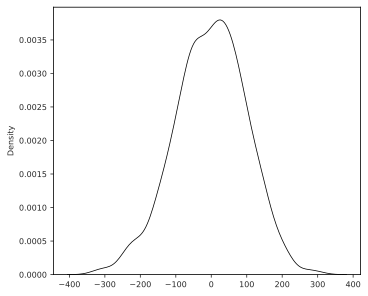

In [33]:
# expectations for the average mpg
sample_intercept = np.random.normal(loc=0, scale=100, size=1000)
sns.kdeplot(sample_intercept);

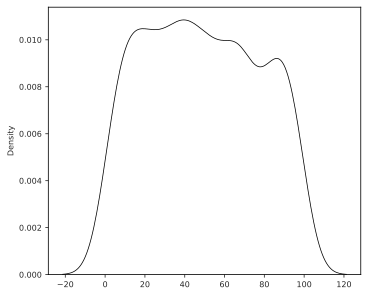

In [34]:
# expectations for model variance
sample_sigma = np.random.uniform(low=0, high=100, size=1000)
sns.kdeplot(sample_sigma);

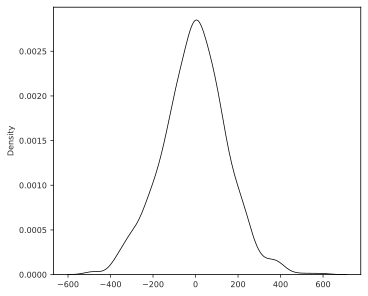

In [35]:
# prior predictive simulation for mpg given the priors
prior_mpg = np.random.normal(loc=sample_intercept+sample_weight, scale=sample_sigma)

sns.kdeplot(prior_mpg);

These priors suggest that the effect of weight on MPG could be anywhere from -400 to 400 points. Definitely not realistic - and these are already more informative priors than any frequentist analysis! Similarly, the expected MPG of a vehicle given these priors is anywhere from -400 to 400.

Let’s bring these in a bit.

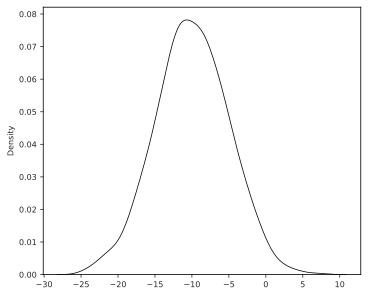

In [36]:
# expectations for the effect of weight on MPG
sample_weight = np.random.normal(loc=-10, scale=5, size=1000)
sns.kdeplot(sample_weight);

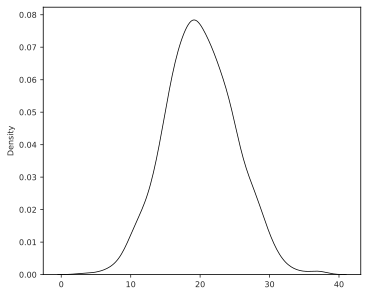

In [37]:
# expectations for the average mpg - alpha
sample_intercept = np.random.normal(loc=20, scale=5, size=1000)
sns.kdeplot(sample_intercept);

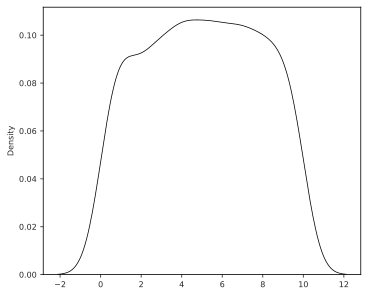

In [38]:
# expectations for model variance
sample_sigma = np.random.uniform(low=0, high=10, size=1000)
sns.kdeplot(sample_sigma);

In [39]:
# prior predictive simulation for mpg given the priors
prior_mpg = np.random.normal(loc=sample_intercept+sample_weight, scale=sample_sigma)

sns.kdeplot(prior_mpg);

We could probably do better, but these look a lot better. Now the expected effect of weight on MPG is negative and and majority of the mass is concentrated between -15 and -5. Similarly, the expected MPG given these priors is between -10 and 20.

#### Improve Stan Model

Now let’s build a new model with these priors and sample from it.

In [40]:
mtcar_model_4_ppc = '''
data {
    int N; //number of observations in the data
    vector[N] mpg; //vector of length n for the car's MPG
    vector[N] weight_c; //vector of length n for the car's weight
    vector[N] cylinders_c; ////vector of length n for the car's cylinders
    vector[N] hp_c; //vector of length n for the car's horsepower
}
parameters {
    real alpha; //the intercept parameter
    real beta_w; //slope parameter for weight
    real beta_c; //slope parameter for cylinder
    real beta_h; //slope parameter for horsepower
    real<lower=0> sigma; //variance parameter and restrict it to positive values
}
model {
    //linear predictor mu
    vector[N] mu;
    
    //write the linear equation
    mu = alpha + beta_w * weight_c + beta_c * cylinders_c + beta_h * hp_c;    
    
    //prior expectations
    alpha ~ normal(20, 5);
    beta_w ~ normal(-10, 5);
    beta_c ~ normal(0, 5); 
    beta_h ~ normal(0, 5);
    sigma ~ uniform(0, 10);    

    //likelihood function
    mpg ~ normal(mu, sigma);
}
generated quantities {
    //replications for the posterior predictive distribution
    array[N] real y_rep;
    y_rep = normal_rng(alpha + beta_w * weight_c + beta_c * 
    cylinders_c + beta_h * hp_c, sigma);
}
'''

stan_model = StanModel('./stan_models/mtcar_model_4_ppc', mtcar_model_4_ppc)

In [41]:
# sample the model
linear_fit_4_ppc = stan_model.sample(data=model_data, show_progress=False)

14:50:00 - cmdstanpy - INFO - CmdStan start processing
14:50:00 - cmdstanpy - INFO - CmdStan start processing
14:50:00 - cmdstanpy - INFO - CmdStan done processing


In [42]:
# summarize the model
summary = linear_fit_4_ppc.summary(percentiles=(5, 95)).round(2)
summary[~summary.index.str.contains('y_rep')]

Mean  MCSE  StdDev   MAD     5%    95%  ESS_bulk  ESS_tail  R_hat
lp__   -46.07  0.05    1.68  1.50 -49.42 -44.02   1188.90   1776.42    1.0
alpha   20.09  0.01    0.47  0.46  19.32  20.86   3853.37   2804.58    1.0
beta_w  -3.32  0.02    0.74  0.73  -4.56  -2.16   1663.63   1603.00    1.0
beta_c  -0.88  0.01    0.57  0.58  -1.80   0.05   1619.29   1853.97    1.0
beta_h  -0.02  0.00    0.01  0.01  -0.04   0.00   1819.07   1873.99    1.0
sigma    2.63  0.01    0.38  0.36   2.10   3.33   1275.68   1208.50    1.0

We can compare the prior distribution to the posterior distribution to see how “powerful” our priors are.

In [43]:
# Convert CmdStanPy (CmdStanMCMC object) data into an InferenceData object 
az_linear_fit_4 = az.from_cmdstanpy(linear_fit_4_ppc, 
                                    posterior_predictive=['y_rep'], 
                                    observed_data={'mpg': mtcars.mpg}, 
                                    dtypes={"y_rep": float})

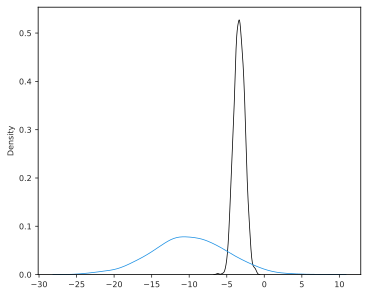

In [44]:
_, axes = plt.subplots()
sns.kdeplot(az_linear_fit_4.posterior.beta_w[0], ax=axes)
sns.kdeplot(sample_weight);

Here we can see that even with more “informative priors” they are still very weak compared to the data.

#### Summarize the Model

With our final model in hand, we can visualizations of our model’s results.

#### Coeficient Plot

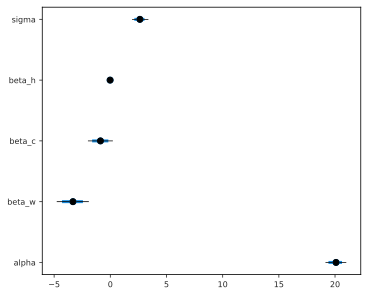

In [45]:
mean_param = az_linear_fit_4.posterior.mean(dim=['chain', 'draw']).to_pandas()
ci_95 = az.hdi(az_linear_fit_4.posterior, hdi_prob=0.95).to_pandas()
ci_80 = az.hdi(az_linear_fit_4.posterior, hdi_prob=0.80).to_pandas()

_, ax = plt.subplots()
ax.errorbar(mean_param.values, mean_param.index, xerr=np.abs(mean_param - ci_80), fmt='C1o', linewidth=3)
ax.errorbar(mean_param.values, mean_param.index, xerr=np.abs(mean_param - ci_95), fmt='C0o');

#### Fitted Regression Line

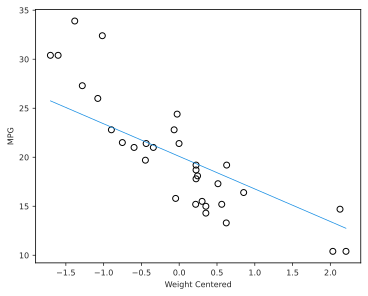

In [46]:
_, ax = plt.subplots()
plt.plot(mtcars.wt_c, mtcars.mpg, 'o', fillstyle='none')
alpha_mean = az_linear_fit_4.posterior.alpha.mean().to_numpy()
beta_w_mean = az_linear_fit_4.posterior.beta_w.mean().to_numpy()
plt.plot(mtcars.wt_c, alpha_mean + (beta_w_mean * mtcars.wt_c))
plt.xlabel('Weight Centered')
plt.ylabel('MPG');

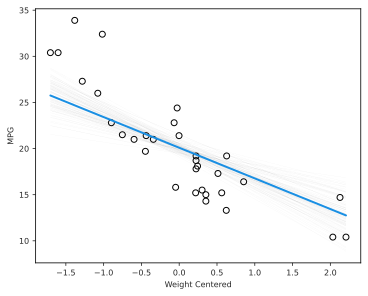

In [47]:
_, ax = plt.subplots()
plt.plot(mtcars.wt_c, mtcars.mpg, 'o', fillstyle='none')

# select a random sample of 100 draws from the posterior distribution
rand_row = np.random.randint(0, 4, size=100)
rand_col = np.random.randint(0, 1000, size=100)
rand_alpha = az_linear_fit_4.posterior.alpha.values[rand_row,rand_col]
rand_beta_w = az_linear_fit_4.posterior.beta_w.values[rand_row,rand_col]
y = rand_alpha + rand_beta_w * mtcars.wt_c.values.reshape(-1,1)
plt.plot(mtcars.wt_c, y, 'k', alpha=0.1, linewidth=0.1)

# add the mean line to the plot
alpha_mean = az_linear_fit_4.posterior.alpha.mean().to_numpy()
beta_w_mean = az_linear_fit_4.posterior.beta_w.mean().to_numpy()
plt.plot(mtcars.wt_c, alpha_mean + (beta_w_mean * mtcars.wt_c), linewidth=2)

plt.xlabel('Weight Centered')
plt.ylabel('MPG');

In [48]:
type(linear_fit_1)

cmdstanpy.stanfit.mcmc.CmdStanMCMC

In [49]:
exceptions = ['In', 'Out', 'exceptions', 'active_variables']

active_variables = [
    var for var, value in globals().items()
    if not var.startswith('_')   # Exclude variables that start with "_"
    and var not in exceptions    # Exclude variables in the exceptions list
    and isinstance(value, (CmdStanModel, cmdstanpy.CmdStanMCMC, plt.Axes, dict, 
                           az.InferenceData, pd.DataFrame, 
                           pd.Series, list, int, float, str, 
                           np.ndarray, np.int64, np.float32))  # Remove these types only
]

for var in active_variables:
    del globals()[var]
del active_variables, exceptions, var

gc.collect()

51856

## Logit and Probit Models

Earlier, we learned how to program and estimate linear models in Stan. Now, we’ll learn how to estimate binary outcome models commonly referred to as **Logit** and **Probit**.

#### Import Data

This time, we’ll use a data on graduate school applicants. This data includes each applicant’s GRE score, GPA, the rank of their undergraduate school, and whether or not they were admitted to graduate school. Our goal is to predict the probability that a student will be admitted.

In [50]:
gre = pd.read_csv('../../data/binary.csv', sep=',', header=0)
gre = gre.rename(columns={'rank': 'ranking'})

### Logit with the Bernoulli Distribution

We could predict whether or not a student is admitted with a Gaussian likelihood function, but then we would be assuming that the outcome is continuous and that both positive and negative values are possible. These are bad assumptions. This data is generated by a process that only produces positive and discrete outcomes. Each application either results in an admit or a reject, values in between are impossible. This means that we’ll need to use a different likelihood function. The Bernoulli distribution seems like a good fit.

The Bernoulli distribution is a probability distribution for a random variable that can have an outcome of 1 with probability $p$ and an outcome of 0 with a probability of $q = 1 - p$. A quick look at the distribution shows that it produces values of 0 and 1.

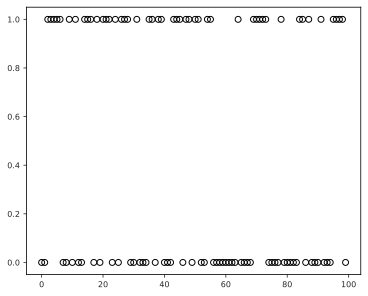

In [51]:
from scipy import stats
plt.plot(stats.bernoulli.rvs(p=0.5, size=100), 'o', fillstyle='none');

You’re probably used to using a binomial likelihood for Logit and Probit models, but the binomial distribution is really meant to describe aggregated counts. The binomial distribution includes an additional parameter for the number of trials that occurred. We’ll see an example of this later. The Bernoulli distribution is essentially equivalent to a binomial distribution with only 1 trial.

#### Build a Logit Model

Here is the model that we want to estimate in Stan:

$$
\begin{aligned}
admit &\sim \text{Bernoulli}(p)\\
\text{Logit}(p) &= \alpha + \beta_1 \text{GRE Score} +  \beta_2 \text{GPA} +  \beta_3 \text{Undergrad Ranking}
\end{aligned}
$$ 

Here we are interesting in estimating the probability that a given student is admitted $p$ using their GRE score, their GPA, and the ranking of their undergraduate school. Notice that we have an additional function in this model: the `Logit()` function.

This function is known as a **“link”** function because it maps the observed 0-1 outcome onto the range of 0-1.0. This link function will prevent the model from predicting outcomes above 1.0 or below 0. When we built our linear model with the normal distribution in the last tutorial, we didn’t need a link function because we were estimating the mean of a continuous outcome (technically we used the **identity link function**).

In [52]:
logit_model_1 = '''
data {              
    int N;                                      // number of observations in the data
    array[N] int<lower=0, upper=1> admit;       // integer of length n for admission decision    
    vector[N] gre;                              // vector of length n for GRE scores
    vector[N] gpa;                              // vector of length n for GPA 
    vector[N] ranking;                          // vector of length n for school ranking     
}
parameters {        
    real alpha;            // intercept parameter
    vector[3] beta;        // vector of beta coefficients (3 coeffs. for 3 predictors)
}
model {
    // linear predictor
    vector[N] p;
    
    // linear equation
    p = alpha + beta[1] * gre + beta[2] * gpa + beta[3] * ranking;

    // likelihood and link function
    admit ~ bernoulli_logit(p);
  
}
'''

stan_model = StanModel('./stan_models/logit_model_1', logit_model_1)

Now let’s prepare the data and estimate the model.

In [53]:
model_data = {
    'admit': gre.admit,
    'gre': gre.gre,
    'gpa': gre.gpa,
    'ranking': gre.ranking,
    'N': len(gre.admit)
}

In [54]:
# sample the model
logit_mode_fit_1 = stan_model.sample(data=model_data, show_progress=False)

14:50:01 - cmdstanpy - INFO - CmdStan start processing
14:50:01 - cmdstanpy - INFO - CmdStan start processing
14:50:06 - cmdstanpy - INFO - CmdStan done processing


In [55]:
summary = logit_mode_fit_1.summary(percentiles=(5,95))
summary.round(2)

Mean  MCSE  StdDev   MAD      5%     95%  ESS_bulk  ESS_tail  R_hat
lp__    -231.73  0.04    1.39  1.21 -234.40 -230.08   1298.48   1768.16    1.0
alpha     -3.48  0.03    1.16  1.20   -5.35   -1.63   1406.04   1834.57    1.0
beta[1]    0.00  0.00    0.00  0.00    0.00    0.00   3257.22   2175.56    1.0
beta[2]    0.79  0.01    0.33  0.33    0.24    1.32   1435.26   1596.65    1.0
beta[3]   -0.56  0.00    0.13  0.13   -0.78   -0.35   1848.99   2000.81    1.0

In [56]:
from scipy.special import expit, logit
round(expit(summary['Mean'])*100, 2)

lp__        0.00
alpha       2.98
beta[1]    50.06
beta[2]    68.68
beta[3]    36.24
Name: Mean, dtype: float64

Here are the interpretations of each coefficient. Notice that they are a bit different since we are using a **Logit link function**. We can “undo” the link function to convert each estimate back to the linear scale.

- `alpha`: For a student with a 0 on the GRE, a GPA of 0, and an undergraduate school ranking of 0, the expected admission probability is $\text{Logit}^{-1}(-3.51)$, which we can calculate in python with `scipy.special.expit(-3.51) * 100 = 2.9029036` percent.
- `beta[1]`: Comparing two applicants who differ by 1 point on the GRE, the model predicts a positive difference in the probability of admission of about 50%.
- `beta[2]`: Comparing two applicants who differ by 1 point in their GPA, the model predicts a positive difference in the probability of admission of about 68%.
- `beta[3]`: Comparing two applicants who differ by 1 point in their undergrad school ranking, the model predicts a positive difference in the probability of admission of about 36%.

When dealing with the logit models, plots can go a long way towards helping us understand the results. We’ll plot the relationship between admission and GPA.

In [57]:
az_logit_fit = az.from_cmdstanpy(logit_mode_fit_1)

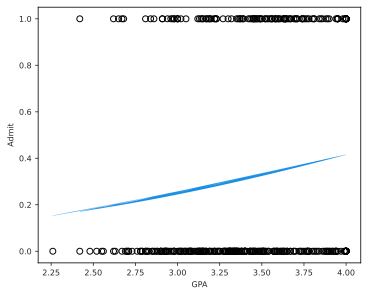

In [58]:
beta_1, beta_2, beta_3 = az_logit_fit.posterior.beta.mean(dim=['chain', 'draw']).to_numpy()
alpha = az_logit_fit.posterior.alpha.mean(dim=['chain', 'draw']).to_numpy()

plt.plot(gre.gpa, gre.admit, 'o', fillstyle='none')
plt.plot(gre.gpa, expit(alpha + beta_2 * gre.gpa), linewidth=0.25)
plt.xlabel('GPA')
plt.ylabel('Admit');

We can also add uncertainty to the plot:

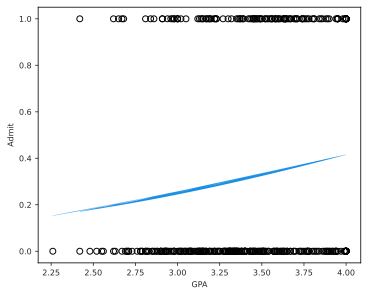

In [59]:
# select a random sample of 100 draws from the posterior distribution
rand_row = np.random.randint(0, 4, size=100)
rand_col = np.random.randint(0, 1000, size=100)
rand_alpha = az_logit_fit.posterior.alpha.values[rand_row,rand_col]
rand_beta_2 = az_logit_fit.posterior.beta.values[rand_row,rand_col][:,1]
y = expit(rand_alpha + rand_beta_2 * gre.gpa.values.reshape(-1,1))
plt.plot(gre.gpa, y, 'k', alpha=0.03, linewidth=0.05)

plt.plot(gre.gpa, gre.admit, 'o', fillstyle='none')
plt.plot(gre.gpa, expit(alpha + beta_2 * gre.gpa), linewidth=0.25)
plt.xlabel('GPA')
plt.ylabel('Admit');

#### Picking Priors for Logit Models

When we are thinking about priors for logit models (or any generalized linear model), it’s important to use the inverse link function to convert back to the linear scale. With the Gaussian model, we can just plot our priors “as-is”, but with logit models we need to “undue” the link function. What is a weak prior on the linear scale might be really informative on the logit scale. To illustrate just how different priors can be, let’s start by using standard weakly informative priors for a normal distribution.

In [60]:
# expectations for the average admission rate
sample_intercept = np.random.normal(0, 10, 1000)
sns.kdeplot(expit(sample_intercept));

With this prior, the model thinks that applicants are either never get accepted or that they always get accepted. This is extreme and we can do better:

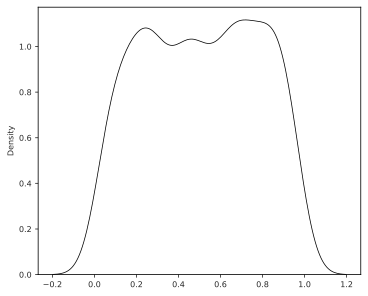

In [61]:
sample_intercept = np.random.normal(0, 1.5, 1000)
sns.kdeplot(expit(sample_intercept));

This is still wide, but already a lot more reasonable. Let’s simulate the rest of the priors.

In [62]:
# expectations for the average admission rate (around 26%)
sample_intercept = np.random.normal(-1, 1.5, 1000)
sns.kdeplot(expit(sample_intercept));

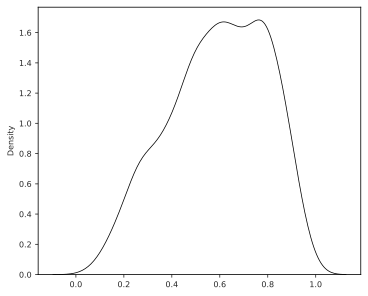

In [63]:
# expectations for the effect of GRE on admission
sample_gre = np.random.normal(0.5, 1, 1000)
sns.kdeplot(expit(sample_gre));

In [64]:
# prior predictive simulation for admission given the priors
prior_admit = stats.bernoulli.rvs(expit(sample_gre + sample_intercept), size=1000)
sns.kdeplot(prior_admit);

Here the model expects that more people are rejected than are accepted. Now we can add these priors into the model along with posterior predictive draws in the generated quantities block:

In [65]:
logit_model_2 = '''
data {              
    int N;                                      // number of observations in the data
    array[N] int<lower=0, upper=1> admit;       // integer array of length n for admission decision    
    vector[N] gre;                              // vector of length n for GRE scores
    vector[N] gpa;                              // vector of length n for GPA 
    vector[N] ranking;                          // vector of length n for school ranking     
}
parameters {        
    real alpha;            // intercept parameter
    vector[3] beta;        // vector of beta coefficients (3 coeffs. for 3 predictors)
}
model {
    // linear predictor
    vector[N] p;
    
    // linear equation
    p = alpha + beta[1] * gre + beta[2] * gpa + beta[3] * ranking;
    
    // prior expectations
    alpha ~ normal(-1, 1.5);
    beta ~ normal(0.5, 1.0);

    // likelihood and link function
    admit ~ bernoulli_logit(p);
}
generated quantities {
    // replications for the posterior predictive distribution
    array[N] real y_rep;
    y_rep = bernoulli_logit_rng(alpha + beta[1] * gre + 
    beta[2] * gpa + beta[3] * ranking);
}
'''

stan_model = StanModel('./stan_models/logit_model_2', logit_model_2)

restimate the model:

In [66]:
# sample the model
logit_mode_fit_2 = stan_model.sample(data=model_data, show_progress=False)

14:50:08 - cmdstanpy - INFO - CmdStan start processing
14:50:08 - cmdstanpy - INFO - CmdStan start processing
14:50:14 - cmdstanpy - INFO - CmdStan done processing


In [67]:
# summarize the model
summary = logit_mode_fit_2.summary(percentiles=(5, 95)).round(2)
summary[~summary.index.str.contains('y_rep')]

Mean  MCSE  StdDev   MAD      5%     95%  ESS_bulk  ESS_tail  R_hat
lp__    -233.35  0.05    1.51  1.28 -236.24 -231.64   1122.59   1222.91    1.0
alpha     -2.61  0.03    0.90  0.90   -4.14   -1.13   1205.01   1433.30    1.0
beta[1]    0.00  0.00    0.00  0.00    0.00    0.00   2855.80   2007.87    1.0
beta[2]    0.58  0.01    0.28  0.27    0.12    1.04   1377.95   1731.20    1.0
beta[3]   -0.58  0.00    0.13  0.12   -0.79   -0.37   1616.82   1513.11    1.0

In [68]:
# Convert CmdStanPy (CmdStanMCMC object) data into an InferenceData object 
az_logit_fit_2 = az.from_cmdstanpy(logit_mode_fit_2, posterior_predictive=['y_rep'], observed_data={'admit': gre.admit}, dtypes={"y_rep": int})
az_logit_fit_2

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

/Users/rehabnaeem/Documents/Coding-Projects/.venv/lib/python3.13/site-packages/arviz/plots/ecdfplot.py:298: BehaviourChangeWarning: In future versions, if `eval_points` is not provided, then the ECDF will be evaluated at the unique values of the sample. To keep the current behavior, provide `eval_points` explicitly.
  warnings.warn(


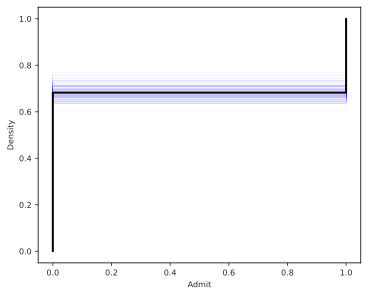

In [69]:
_, axes = plt.subplots()
for _ in range(100):
    rand_row = np.random.randint(0, 4)
    rand_col = np.random.randint(0, 1000)
    az.plot_ecdf(az_logit_fit_2.posterior_predictive.y_rep[rand_row, rand_col], ax=axes, 
                 plot_kwargs={'color':'b', 'alpha':0.2, 'linewidth':0.2})
az.plot_ecdf(gre.admit, ax=axes, 
             plot_kwargs={'color':'k', 'linewidth':2})    
axes.set(ylabel='Density', xlabel='Admit');

### Probit Model with the Bernoulli Distribution

We can change the logit link to a probit link with the `Phi` function in Stan, which is the **cumulative normal distribution function**:

In [70]:
probit_model_1 = '''
data {              
    int N;                                      // number of observations in the data
    array[N] int<lower=0, upper=1> admit;       // integer of length n for admission decision    
    vector[N] gre;                              // vector of length n for GRE scores
    vector[N] gpa;                              // vector of length n for GPA 
    vector[N] ranking;                          // vector of length n for school ranking     
}
parameters {        
    real alpha;            // intercept parameter
    vector[3] beta;        // vector of beta coefficients (3 coeffs. for 3 predictors)
}
model {
    // linear predictor
    vector[N] p;
    
    // linear equation
    p = alpha + beta[1] * gre + beta[2] * gpa + beta[3] * ranking;

    // likelihood and link function
    admit ~ bernoulli(Phi(p));
}
'''

stan_model = StanModel('./stan_models/probit_model_1', probit_model_1)

Sampling from the model:

In [78]:
# sample the model
probit_mode_fit_1 = stan_model.sample(data=model_data, show_progress=False)

14:50:27 - cmdstanpy - INFO - CmdStan start processing
14:50:28 - cmdstanpy - INFO - CmdStan start processing
14:50:36 - cmdstanpy - INFO - CmdStan done processing


In [79]:
summary = probit_mode_fit_1.summary(percentiles=(5,95))
summary.round(2)

Mean  MCSE  StdDev   MAD      5%     95%  ESS_bulk  ESS_tail  R_hat
lp__    -250.34  0.04    1.50  1.22 -253.29 -248.63   1363.78   1344.58    1.0
alpha      0.27  0.02    0.64  0.62   -0.78    1.34   1223.16   1401.55    1.0
beta[1]   -0.00  0.00    0.00  0.00   -0.00    0.00   3108.23   2493.30    1.0
beta[2]   -0.07  0.01    0.19  0.18   -0.39    0.23   1226.61   1355.02    1.0
beta[3]   -0.12  0.00    0.07  0.07   -0.24   -0.01   1430.98   1547.77    1.0

To “undue” the probit link function, we can use `stats.norm.cdf()` in Python. After doing this, we see that the coefficient estimates are very similar to the logit link function.

### Aggregated Events

When we’re dealing with aggregated 0-1 data, we need to use the binomial distribution.

For an example of this, we’ll use a data set on graduate admissions to UC Berkeley.

In [80]:
admit_data = pd.read_csv('../../data/UCBAdmissions.csv', sep=',', header=0)
admit_data.head()

rownames     Admit  Gender Dept  Freq
0         1  Admitted    Male    A   512
1         2  Rejected    Male    A   313
2         3  Admitted  Female    A    89
3         4  Rejected  Female    A    19
4         5  Admitted    Male    B   353

Here we have the total number of applicants admitted and rejected by gender and department. Let’s use this data to test for gender discrimination in admissions. To do this, we’ll build a model with a binomial likelihood function:

In [81]:
binom_logit_model = '''
data {
    int N; 
    array[N] int admit;
    array[N] int applications; //number of applications for each outcome
    vector[N] gender;
}

parameters {
    real alpha;
    vector[1] beta;
}

model {
    //linear model
    vector[N] p;
    p = alpha + beta[1] * gender;

    //likelihood and link function
    admit ~ binomial_logit(applications, p);
}
'''

stan_model = StanModel('./stan_models/binom_logit_model', binom_logit_model)

Notice the binomial likelihood involves an additional parameter: the number of trials for each outcome. This is captured by the `applications` variable.

In [82]:
model_data = {
    'admit': (admit_data['Admit'] != 'Rejected').astype(int),
    'applications': admit_data.Freq,
    'gender': (admit_data['Gender'] != 'Female').astype(int),
    'N': len(admit_data.Admit)
}

In [83]:
# sample the model
binom_logit_model_fit = stan_model.sample(data=model_data, show_progress=False)

14:50:36 - cmdstanpy - INFO - CmdStan start processing
14:50:36 - cmdstanpy - INFO - CmdStan start processing
14:50:36 - cmdstanpy - INFO - CmdStan done processing


In [84]:
summary = binom_logit_model_fit.summary(percentiles=(5,95))
summary.round(2)

Mean  MCSE  StdDev   MAD     5%    95%  ESS_bulk  ESS_tail  R_hat
lp__    -83.99  0.03    1.08  0.72 -86.11 -83.01   1463.64   1439.93    1.0
alpha    -5.80  0.01    0.43  0.41  -6.56  -5.15   1275.85   1173.71    1.0
beta[1]  -0.39  0.02    0.61  0.60  -1.39   0.59   1232.70   1535.20    1.0

In [85]:
exceptions = ['In', 'Out', 'exceptions', 'active_variables']

active_variables = [
    var for var, value in globals().items()
    if not var.startswith('_')   # Exclude variables that start with "_"
    and var not in exceptions    # Exclude variables in the exceptions list
    and isinstance(value, (CmdStanModel, cmdstanpy.CmdStanMCMC, plt.Axes, dict, 
                           az.InferenceData, pd.DataFrame, 
                           pd.Series, list, int, float, str, 
                           np.ndarray, np.int64, np.float32))  # Remove these types only
]

for var in active_variables:
    del globals()[var]
del active_variables, exceptions, var

gc.collect()

52967

## Multilevel Modeling in Stan

There are a few different ways to model data that contains repeated observations for units over time, or that is nested within groups. First, we could simply pool all the data together and ignore the nested structure (**pooling**). Second, we could consider observations from each group as entirely independent from observations in other groups (**no pooling**). Finally, we could use information about the similarity of observations within groups to inform our individual estimates (**partial pooling**).

#### Import Data

In [86]:
radon = pd.read_csv('../../data/radon.csv', sep=',', header=0)
radon.head()

Unnamed: 0  floor  county  log_radon  log_uranium
0           1      1  AITKIN   0.832909    -0.689048
1           2      0  AITKIN   0.832909    -0.689048
2           3      0  AITKIN   1.098612    -0.689048
3           4      0  AITKIN   0.095310    -0.689048
4           5      0   ANOKA   1.163151    -0.847313

### Pooling

Let’s start with the pooling estimates. As a point of reference, we’ll fit a frequentist model first.

#### Frequentist Fit

In [87]:
import statsmodels.api as sm

# fit model
pooling_fit = sm.OLS(radon.log_radon, sm.add_constant(radon.floor)).fit()
pooling_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_radon   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     70.25
Date:                Sun, 23 Feb 2025   Prob (F-statistic):           1.95e-16
Time:                        14:50:37   Log-Likelihood:                -1086.5
No. Observations:                 919   AIC:                             2177.
Df Residuals:                     917   BIC:                             2187.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3624      0.029     47.725      0.000       1.306       1.418
floor         -0.5864      0.070     -8.382      0.000      -0.724      -0.449
==============================================================================
Omnibus:                       14.572   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.471
Skew:                          -0.139   Prob(JB):                     2.18e-05
Kurtosis:                       3.696   Cond. No.                         2.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/rehabnaeem/Documents/Coding-Projects/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/rehabnaeem/Documents/Coding-Projects/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


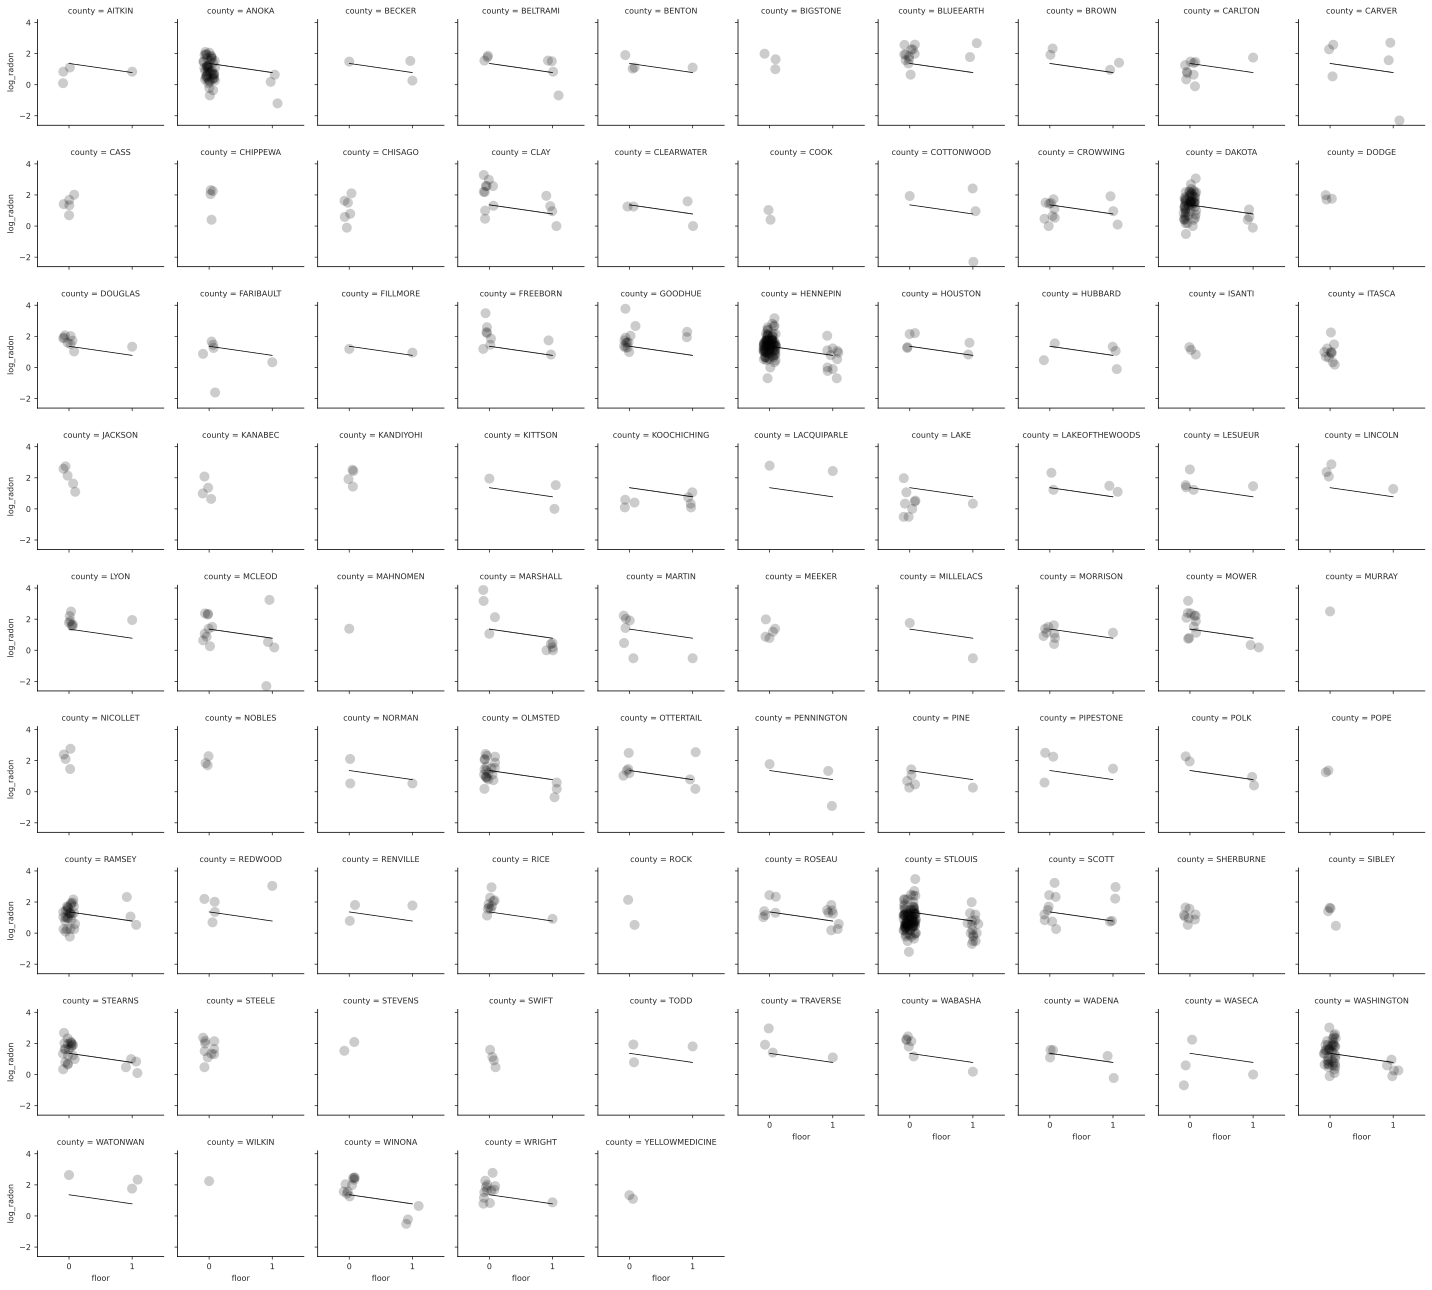

In [94]:
# calculate fitted values
radon['pooling_fit'] = pooling_fit.fittedvalues

g = sns.FacetGrid(radon, col='county', 
                  col_wrap=10, height=2,
                  sharex=True, sharey=True)
g.map(sns.lineplot, 'floor', 'pooling_fit')
g.map(sns.stripplot, 'floor', 'log_radon', alpha=0.2, size=10);

#### Bayesian Fit

In [89]:
multi_lev_pooling_model = '''
data {
    int N; 
    vector[N] log_radon;
    vector[N] vfloor;
}
parameters {
    real alpha;                  // intercept parameter
    real beta;                   // slope parameter
    real<lower=0> sigma;         // variance parameter
}
model {
    //  conditional mean
    vector[N] mu;
    
    // linear function
    mu = alpha + beta * vfloor;

    // priors
    alpha ~ normal(0, 100);
    beta ~ normal(0, 100);
    sigma ~ uniform(0, 100);
    
    // likelihood function
    log_radon ~ normal(mu, sigma);
}
generated quantities {
    vector[N] log_lik;   // calculate log-likelihood
    vector[N] y_rep;     // replications from posterior predictive distribution
    
    for (i in 1:N) {
        // generate mpg predicted value
        real log_radon_hat = alpha + beta * vfloor[i];
        
        // calculate log-likelihood
        log_lik[i] = normal_lpdf(log_radon[i] | log_radon_hat, sigma);
        // normal_lpdf is the log of the normal probability density function
        
        // generate replication values
        y_rep[i] = normal_rng(log_radon_hat, sigma);
        // normal_rng generates random numbers from a normal distribution
    }
}
'''

stan_model = StanModel('./stan_models/multi_lev_pooling_model', multi_lev_pooling_model)

In [90]:
model_data = {
    'log_radon': radon.log_radon,
    'vfloor': radon.floor,
    'N': len(radon.log_radon)
}

# sample the model
multi_lev_pooling_fit = stan_model.sample(data=model_data, show_progress=False)

14:50:52 - cmdstanpy - INFO - CmdStan start processing
14:50:52 - cmdstanpy - INFO - CmdStan start processing
14:50:53 - cmdstanpy - INFO - CmdStan done processing


In [91]:
# summarize our model
multi_lev_pooling_fit.summary(percentiles=(5, 95)).round(2)

Mean  MCSE  StdDev   MAD      5%     95%  ESS_bulk  ESS_tail  \
lp__       -243.67  0.03    1.17  0.99 -245.92 -242.41   1686.17   2684.48   
alpha         1.36  0.00    0.03  0.03    1.32    1.41   2910.63   3061.54   
beta         -0.59  0.00    0.07  0.07   -0.70   -0.47   2702.32   2716.74   
sigma         0.79  0.00    0.02  0.02    0.76    0.82   3243.89   2582.42   
log_lik[1]   -0.69  0.00    0.02  0.02   -0.73   -0.65   3238.94   2734.58   
...            ...   ...     ...   ...     ...     ...       ...       ...   
y_rep[915]    1.36  0.01    0.80  0.77    0.04    2.69   4067.35   3802.11   
y_rep[916]    1.36  0.01    0.79  0.79    0.07    2.65   3876.15   3777.25   
y_rep[917]    1.36  0.01    0.80  0.80    0.05    2.65   3970.99   3872.83   
y_rep[918]    1.39  0.01    0.80  0.78    0.07    2.70   3930.14   4187.11   
y_rep[919]    1.39  0.01    0.77  0.76    0.12    2.71   3968.95   3489.73   

            R_hat  
lp__          1.0  
alpha         1.0  
beta          1.0  
sigma         1.0  
log_lik[1]    1.0  
...           ...  
y_rep[915]    1.0  
y_rep[916]    1.0  
y_rep[917]    1.0  
y_rep[918]    1.0  
y_rep[919]    1.0  

[1842 rows x 9 columns]

In [92]:
az_pooling_fit = az.from_cmdstanpy(multi_lev_pooling_fit, posterior_predictive='y_rep',
                  observed_data={'log_radon': radon.log_radon}, log_likelihood='log_lik', 
                  dtypes={"y_rep": float, 'log_lik': float})
az_pooling_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

/Users/rehabnaeem/Documents/Coding-Projects/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/rehabnaeem/Documents/Coding-Projects/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


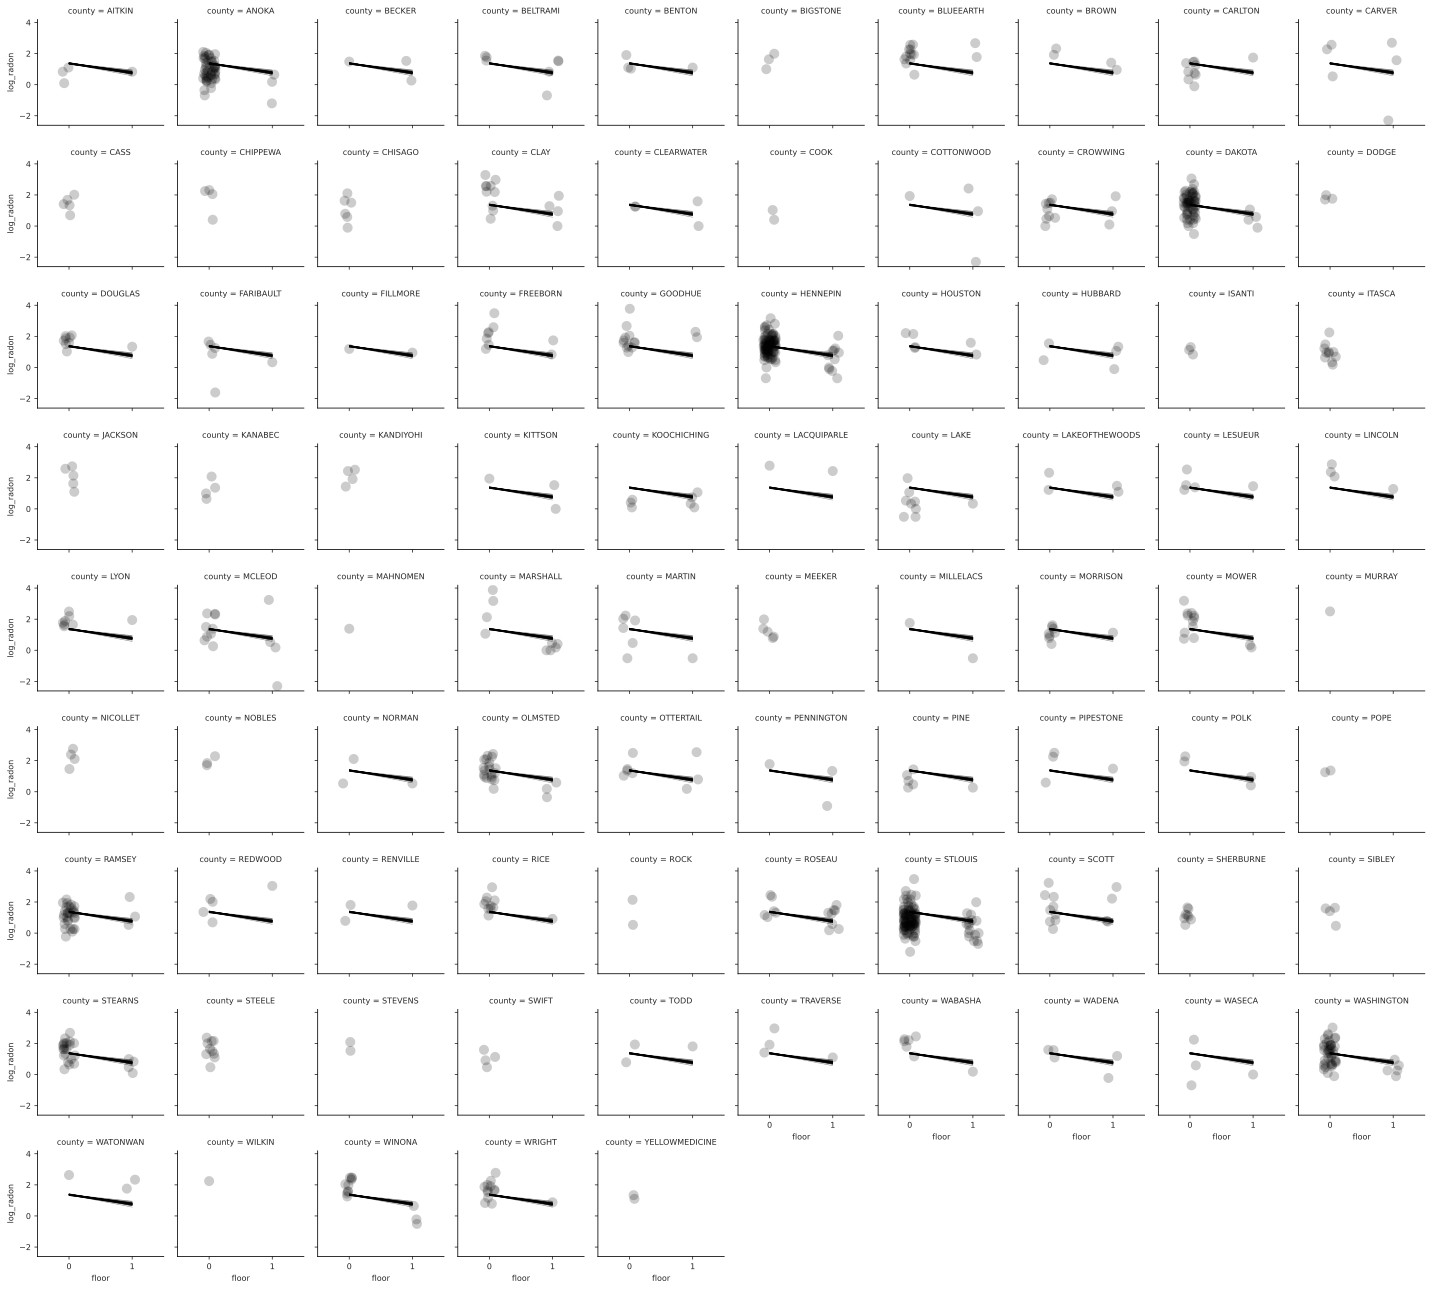

In [144]:
stan_pooling_samples = az.extract(az_pooling_fit, group='posterior', 
                                  var_names=['alpha', 'beta'], combined=True,
                                  num_samples=50).to_dataframe()

def plot_posterior_fits(x, y, **kwargs):
    county_name = kwargs["data"]["county"].iloc[0]
    subset = radon[radon['county'] == county_name]
    x_vals = subset['floor'].unique().reshape(-1, 1)
    y_preds = stan_pooling_samples.alpha.values + stan_pooling_samples.beta.values * x_vals
    plt.plot(x_vals, y_preds, color='k', alpha=0.5, lw=0.5)

g = sns.FacetGrid(radon, col='county', col_wrap=10, height=2, sharex=True, sharey=True)
g.map_dataframe(plot_posterior_fits, 'floor', 'log_radon')
g.map(sns.stripplot, 'floor', 'log_radon', alpha=0.2, size=10);

In [146]:
exceptions = ['radon', 'In', 'Out', 'exceptions', 'active_variables']

active_variables = [
    var for var, value in globals().items()
    if not var.startswith('_')   # Exclude variables that start with "_"
    and var not in exceptions    # Exclude variables in the exceptions list
    and isinstance(value, (CmdStanModel, cmdstanpy.CmdStanMCMC, sns.FacetGrid, plt.Axes, dict, 
                           az.InferenceData, pd.DataFrame, 
                           pd.Series, list, int, float, str, 
                           np.ndarray, np.int64, np.float32))  # Remove these types only
]
print(active_variables)
for var in active_variables:
    del globals()[var]
del active_variables, exceptions, var

gc.collect()

['g']


476040

### No Pooling

Now lets move to the no pooling estimates. These are sometimes referred to as “fixed-effects” by economists because you control for grouped data structures by including indicator variables to the grouping units. To give you a reference point, we’ll fit this model in a frequentist framework first.